In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
import pandas as pd
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import StepLR

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [3]:
with open('data/processed_corpus.json', 'r', encoding='utf-8') as f:
    corpus = json.load(f)

In [4]:
len(corpus)

100000

In [5]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [6]:
sample_text = corpus[1]

In [7]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [8]:
# MY CODE

def pad_context(context, window, pad_token, right):
    pads = [pad_token] * (window - len(context))
    if right:
        result = pads + context
    else:
        result = context + pads
    return result

In [9]:
# MY CODE

def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    for ind in range(len(tokens)):
        start = ind - window
        if ind < window:
            start = 0
        rigth_context = tokens[start:ind]
        left_context = tokens[ind+1:ind+window+1]
        rigth_context = pad_context(rigth_context, window, pad_token, right=True)
        left_context = pad_context(left_context, window, pad_token, right=False)
        splits.append([rigth_context, tokens[ind], left_context])
        
    return splits

In [10]:
splits = cbow_split(sample_text, window=2)

In [13]:
# for sample in splits:
#     print('Левый контекст:', sample[0])
#     print('Центральное слово:', sample[1])
#     print('Правый контекст:', sample[2], end='\n\n')

In [14]:
splits

[[['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']],
 [['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']],
 [['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']],
 [['денежный', 'средство'], 'лицевой', ['счёт', 'либо']],
 [['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']],
 [['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']],
 [['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']],
 [['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']],
 [['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']],
 [['счёт', 'погашение'], 'кредит', ['PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [15]:
cbow_split(sample_text, window=3)

[[['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']],
 [['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']],
 [['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']],
 [['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']],
 [['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']],
 [['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']],
 [['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']],
 [['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']],
 [['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']],
 [['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

# Реализуйте разделение предложения на примеры методом Skipgram

In [16]:
# MY CODE

def skipgram_split(tokens, window):
    
    splits = []
    
    for ind in range(len(tokens)):
        start = ind - window
        if ind < window:
            start = 0
        context = tokens[start:ind+window+1]
        context.remove(tokens[ind])
        for cont_word in context:
            splits.append((cont_word, tokens[ind]))
            
    return splits

In [17]:
splits = skipgram_split(sample_text, window=2)

In [18]:
# for sample in splits:
#     print('Контекст:', sample[0])
#     print('Центральное слово:', sample[1], end='\n\n')

In [19]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('зачесть', 'погашение'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('счёт', 'кредит'),
 ('погашение', 'кредит')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [20]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('вернуть', 'лицевой'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('денежный', 'счёт'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('средство', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('погашение', 'либо'),
 ('лицевой', 'зачесть'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('кредит', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('либо', 'погашение'),
 ('зачесть', 'погашени

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [21]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [22]:
len(word2index)

13076

In [23]:
word2index['UNK']

1

In [24]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [25]:
from torch.utils.data import Dataset, DataLoader

In [26]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [27]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.18537592, 0.89473409, 0.79813383, 0.22321757],
       [0.52475927, 0.91072199, 0.03946153, 0.9830679 ],
       [0.66056502, 0.73540644, 0.09589861, 0.53859183],
       [0.95282628, 0.15575165, 0.77246288, 0.23862743],
       [0.15362433, 0.99735779, 0.54926657, 0.62683201],
       [0.29535088, 0.40441163, 0.92273102, 0.16808868],
       [0.77304091, 0.30386124, 0.12786832, 0.8901165 ],
       [0.02866364, 0.7027889 , 0.82422111, 0.50681234],
       [0.94794087, 0.93349414, 0.209576  , 0.66672959],
       [0.90281659, 0.81323102, 0.85681568, 0.13697538]])

In [28]:
some_data_y

array([0, 1, 2, ..., 0, 1, 2])

In [29]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [30]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [31]:
some_dataset[5], some_dataset[467]

((array([0.29535088, 0.40441163, 0.92273102, 0.16808868]), 0),
 (array([0.40924969, 0.23947674, 0.08851697, 0.72464521]), 1))

In [32]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [33]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.3609, 0.9489, 0.5384, 0.6373],
         [0.4614, 0.7975, 0.8048, 0.3091],
         [0.8835, 0.0850, 0.1099, 0.5360],
         [0.9442, 0.5061, 0.5274, 0.8555],
         [0.2779, 0.5184, 0.8531, 0.6990],
         [0.3070, 0.2912, 0.8211, 0.4560],
         [0.7140, 0.8310, 0.7569, 0.3475],
         [0.5108, 0.8268, 0.7119, 0.4265],
         [0.9779, 0.8331, 0.6491, 0.8061],
         [0.0198, 0.9121, 0.3228, 0.7223],
         [0.6468, 0.6013, 0.2769, 0.9564],
         [0.9648, 0.6922, 0.1419, 0.6771],
         [0.4794, 0.6420, 0.0085, 0.2782],
         [0.2284, 0.7946, 0.5325, 0.4329],
         [0.5551, 0.5015, 0.2459, 0.2977],
         [0.1021, 0.1060, 0.0751, 0.7620]], dtype=torch.float64))

In [34]:
for x, y in some_loader:
    pass

len(x)

15

In [35]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [36]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [37]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [38]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [39]:
for x, y in toy_loader:
    break

In [40]:
x.shape

torch.Size([128, 32])

In [41]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.1854,   0.8947,   0.7981,  ...,  -0.6674,  -1.3529,  -8.9977],
        [  0.5248,   0.9107,   0.0395,  ...,  -0.5611, -19.3946,  -0.1025],
        [  0.6606,   0.7354,   0.0959,  ...,  -1.8440, -14.0668,  -3.7128],
        ...,
        [  0.9072,   0.6113,   0.7468,  ...,  -2.9532,  -1.7518,  -0.2699],
        [  0.7408,   0.6545,   0.1097,  ...,  -2.5430, -13.2624,  -9.3388],
        [  0.2333,   0.3598,   0.8735,  ...,  -6.1338,  -0.8114,  -4.6648]],
       dtype=torch.float64)

In [42]:
y

tensor([0, 1, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 1, 2, 1, 1, 1,
        2, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2,
        2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 2, 0,
        2, 0, 1, 0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 2, 0, 0, 1, 1,
        0, 2, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0,
        0, 2, 1, 1, 1, 1, 0, 1], dtype=torch.int32)

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [43]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [44]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y.long())
    
loss.item()

1.1181213855743408

# Боевые датасеты

In [45]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [46]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        
        # MY CODE
        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # MY CODE
        splits = []
        
        for ind in range(len(tokenized_text)):
            start = ind - self.window
            if ind < self.window:
                start = 0
            context = tokenized_text[start:ind + self.window + 1]
            context.remove(tokenized_text[ind])
            for cont_word in context:
                splits.append((cont_word, tokenized_text[ind]))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # MY CODE
        context, central_word = self.data[idx]
        return context, central_word

In [47]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 127225.84it/s]


In [48]:
BATCH_SIZE = 512

In [49]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [50]:
for x, y in dataset_loader:
    break

In [51]:
x[:5]

tensor([ 724,  465,  886,  220, 1279])

In [52]:
y[:5]

tensor([   2,   16, 2659,  680,  863])

In [53]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [54]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [55]:
# MY CODE
class SkipGram(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        return x

In [56]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [57]:
np.random.seed(42)
torch.manual_seed(42)

In [58]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [59]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

In [60]:
model = model.to(device)

# Допишите обучалку

In [61]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for i, (x, y) in enumerate(dataset_loader):
            
            # MY CODE
            
            x = x.to(device)
            y = y.to(device)
            
#             optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|████████████████████████████████████████████████| 2983124/2983124 [00:25<00:00, 115486.46it/s, loss=7.13]


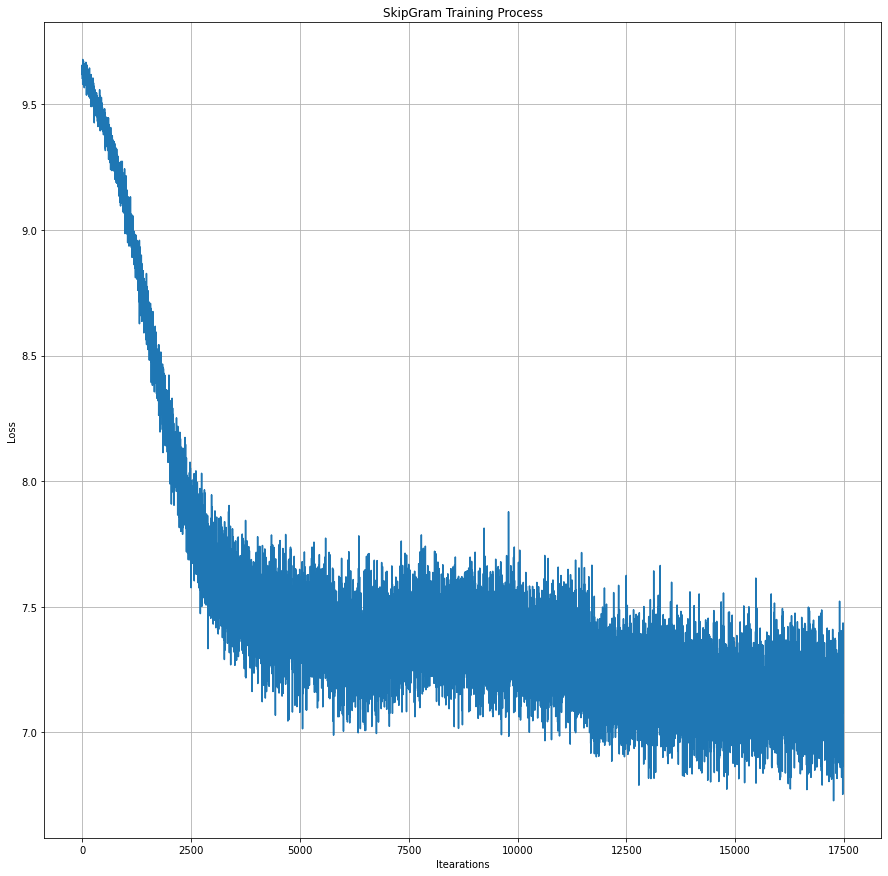

In [62]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [63]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [64]:
embedding_matrix = model.in_embedding.weight.detach()

In [65]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [66]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.5636844635009766

In [67]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.43883034586906433

In [68]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.47372308373451233

In [69]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.6509906053543091

In [70]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.5636844635009766

In [71]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудник')

0.9999999403953552

In [72]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "видеть" равна 0.315'

In [73]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [74]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [75]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix.cpu())

C:\Users\user\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.000s...
[t-SNE] Computed neighbors for 13076 samples in 4.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

C:\Users\user\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 96.8579483, gradient norm = 0.0000791 (50 iterations in 2.882s)
[t-SNE] Iteration 100: error = 96.8680267, gradient norm = 0.0000050 (50 iterations in 2.180s)
[t-SNE] Iteration 150: error = 96.8680191, gradient norm = 0.0000020 (50 iterations in 2.292s)
[t-SNE] Iteration 200: error = 96.8680191, gradient norm = 0.0000025 (50 iterations in 2.313s)
[t-SNE] Iteration 250: error = 96.8680191, gradient norm = 0.0000021 (50 iterations in 2.248s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.868019
[t-SNE] Iteration 300: error = 4.7210031, gradient norm = 0.0009740 (50 iterations in 2.457s)
[t-SNE] Iteration 350: error = 4.2244439, gradient norm = 0.0005458 (50 iterations in 2.826s)
[t-SNE] Iteration 400: error = 4.1019769, gradient norm = 0.0002991 (50 iterations in 2.541s)
[t-SNE] Iteration 450: error = 4.0241933, gradient norm = 0.0002098 (50 iterations in 2.724s)
[t-SNE] Iteration 500: error = 3.9685249, gradient norm = 0.0001568 (50 

In [76]:
top_words = [a for a,_ in top_sorted_freq]

In [77]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

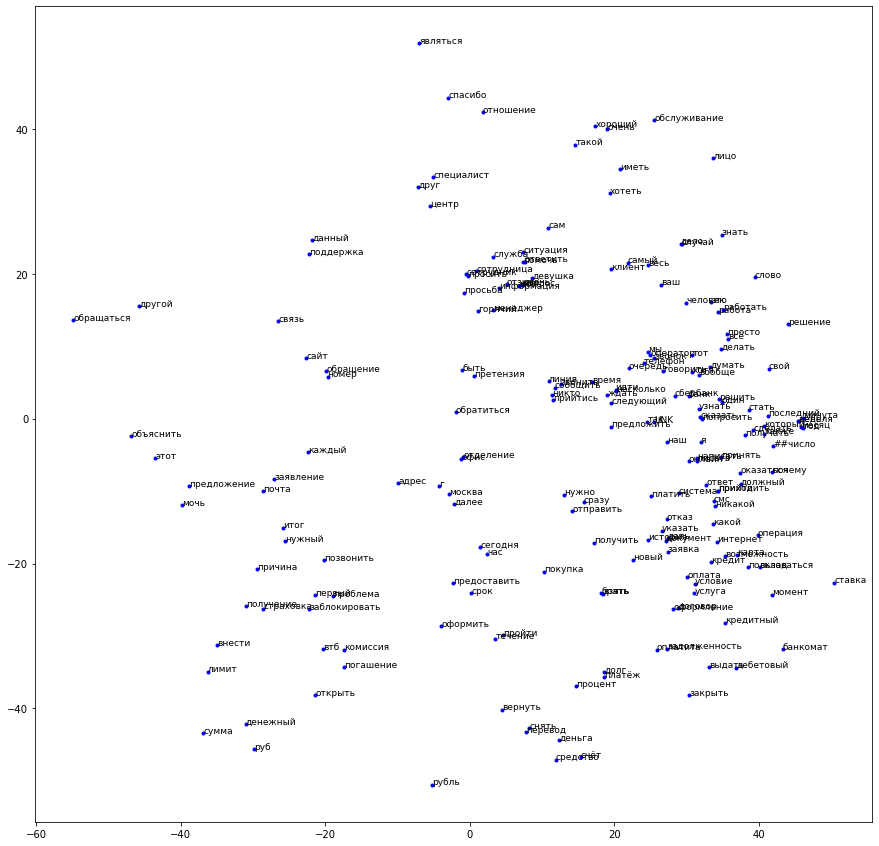

In [110]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

## Задание 2
Оценка эмбеддингов

#### Данные

In [78]:
emb_df = pd.read_csv('ru_simlex965_tagged.tsv', sep='\t')

In [79]:
emb_df['# Word1'] = emb_df['# Word1'].str.split('_').str[0]
emb_df['Word2'] = emb_df['Word2'].str.split('_').str[0]
emb_df['Average Score'] = emb_df['Average Score']/10

In [80]:
emb_df.head()

,# Word1,Word2,Average Score
0,авария,бедствие,0.615
1,август,месяц,0.285
2,авиация,полет,0.677
3,автомобиль,гудок,0.185
4,автомобиль,автострада,0.123


#### Подсчет близостей на своих векторах

In [81]:
words_1 = emb_df['# Word1'].values.tolist()
words_2 = emb_df['Word2'].values.tolist()

In [82]:
gold_scores = [emb_df['Average Score'].iloc[i] for i in range(len(emb_df)) 
                         if words_1[i] in word2index and words_2[i] in word2index]

In [83]:
my_scores = [cos_sim(embedding_matrix, word2index, 
                     words_1[i], words_2[i]) for i in range(len(emb_df)) 
                         if words_1[i] in word2index and words_2[i] in word2index]
my_scores = np.array(my_scores)

In [84]:
my_scores_norm = (np.array(my_scores) + 1) / 2

#### Оценка качества

В задании сказано отнормировать оба набора данных: и стандарт, и мои scores. Но я заметила, что в стандарте нет отрицательных значений, а в моих показателях они могут быть, потому что косинусная близость может быть отрицательной. Я предлагаю не нормировать свои показатели. 

* В данных есть пары слова с явным отношением родства, но с очень низким score, например *автомобиль - автострада - 0.123*, *август - месяц - 0.285*. Если нормировать свои показатели, которые были в промежутке от [-1; 1] к промежутку [0; 1], то получается, что в таких парах мы ждем, что наши эмбеддинги дадут отрицательную косинусную близость. Кажется, это неправильно - слова однозначно имеют смысловую связь и не являются антонимами.
* В "золотых" данных почти нет антонимов, поэтому мы не ждем, что на наших эбмеддингах будут получаться отрицательные scores. Такие все-таки обнаружились (см. ниже), но слова в таких парах имеют некоторый вид отношений родства, поэтому я буду брать модуль от полученных значений косинусной близости. 
* Так, подсчет своих показателей на "золотых" данных, в которых все слова с определенным родством, мы будем всегда получать значения [0; 1], показывающие степпень родства, близости.
* Подсчет MSE тоже показывает, что не нормировать свои данные в этом случае правильнее. Все-таки не хочется портить свои эмбеддинги, просто чтобы подогнать к "золотым" данным, поэтому я сделаю, как, по-моему, логичнее.

In [85]:
mse = mean_squared_error(gold_scores, my_scores_norm)
print(f'MSE на нормированных данных: {mse:.3f}')

MSE на нормированных данных: 0.230


In [86]:
mse = mean_squared_error(gold_scores, np.abs(my_scores))
print(f'MSE, если свои данные не нормировать: {mse:.3f}')

MSE, если свои данные не нормировать: 0.121


In [87]:
neg_similarities = np.where(my_scores < 0)[0]
taken_words = [(words_1[i], words_2[i]) for i in range(len(emb_df)) 
                         if words_1[i] in word2index and words_2[i] in word2index]
print('Слова, у которых отрицательная косинусная близость:')
np.array(taken_words)[neg_similarities]

Слова, у которых отрицательная косинусная близость:


array([['взрослый', 'опекун'],
       ['завтрак', 'ужин'],
       ['крошечный', 'огромный'],
       ['низ', 'верх'],
       ['остров', 'задача'],
       ['пиво', 'шампанское'],
       ['расширяться', 'расти'],
       ['река', 'поток'],
       ['река', 'море'],
       ['сообразительный', 'интеллектуальный'],
       ['ужин', 'завтрак'],
       ['чета', 'пара']], dtype='<U16')

### Задание 3
Улучшение показателей

Добавлю
* Обнуление градиентов на каждом сотом шаге. 
* Изменение learning rate с помощью StepLR.

In [95]:
np.random.seed(42)
torch.manual_seed(42)

In [96]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
model = model.to(device)

In [97]:
learning_rate = 0.001

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=1, gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [98]:
epochs = 3

losses = []

for n_epoch in range(epochs):
    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for i, (x, y) in enumerate(dataset_loader):
            x = x.to(device)
            y = y.to(device)
            
            # Добавим обнуление градиентов
            if i % 100 == 0:
                optimizer.zero_grad()
                
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(x.shape[0])
        progress_bar.close()
        
        # Добавим изменение learning rate
        scheduler.step()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 1: 100%|████████████████████████████████████████████████| 2983124/2983124 [00:26<00:00, 110568.68it/s, loss=6.91]


Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 2: 100%|████████████████████████████████████████████████| 2983124/2983124 [00:23<00:00, 124927.33it/s, loss=6.76]


Adjusting learning rate of group 0 to 2.5000e-04.


Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [00:24<00:00, 120688.59it/s, loss=6.7]

Adjusting learning rate of group 0 to 1.2500e-04.


In [99]:
embedding_matrix = model.in_embedding.weight.detach()

In [100]:
# убедимся, что косинусные близости выглядят адекватно

cos_sim(embedding_matrix, word2index, 'день', 'месяц'), cos_sim(embedding_matrix, word2index, 'день', 'собака')

(0.7496617436408997, 0.06531602889299393)

In [101]:
my_scores = [cos_sim(embedding_matrix, word2index, 
                     words_1[i], words_2[i]) for i in range(len(emb_df)) 
                         if words_1[i] in word2index and words_2[i] in word2index]
my_scores = np.array(my_scores)

In [102]:
mse = mean_squared_error(gold_scores, np.abs(my_scores))
print(f'Новое MSE: {mse:.3f}')

Новое MSE: 0.113


* Изначальное MSE = 0.121
* MSE с добавлением обнуления градиентов и lr=0.001 понизилось до 0.118
* MSE c обнулением градиентов и изменением lr через StepLR снизилось 0.113

Еще пробовала:
* Учить с window=3. MSE выросло до 0.133
* Использовать AdamW вместо Adam - MSE 0.125

Ну, и еще можно увеличить количество эпох. Это увеличит качество, но и изначальная модель обучится лучше, если увеличить ей количество эпох.

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов